In [1]:
import tensorflow as ts
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import session_info

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
session_info.show()

In [3]:
INIT_LR = 1e-4  # Initial Learning Rate
EPOCHS = 15    # How many runs of trainings
BS = 64         # Batch Size of the training
DIRECTORY = r"dataset"
CATEGORIES = ["with_mask", "without_mask"]
data = []   #Image arrays are appended in it
labels = [] #Appends image labels

data_dir = pathlib.Path("dataset")
image_countTotal = len(list(data_dir.glob('*/*')))
image_countMask = len(list(data_dir.glob('with_mask/*')))
image_countWithoutMask = len(list(data_dir.glob('without_mask/*')))
print("Total = ",image_countTotal, ", with_mask = ", image_countMask, ", without_mask = ",image_countWithoutMask )


Total =  6000 , correctly Masked =  0 , incorrectly or without mask =  0


In [4]:
print("[INFO] loading images")
for category in CATEGORIES:
    print(datetime.now()," - Loading "+category+"")
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)  #specific path of one img
        # LOAD IMAGE AND CONVERT SIZE
        image = load_img(img_path,target_size=(256,256))
        image = img_to_array(image) #KERAS: convert image to array
        image = preprocess_input(image) #MobileNetV2

        # Append Image to data list
        data.append(image)

        # Appends labels to label list
        labels.append(category)
    print(datetime.now()," - Loaded "+category+"")

[INFO] loading images
2022-06-03 13:07:40.348348  - Loading with_mask


/Users/leequan/miniforge3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2022-06-03 13:07:56.075344  - Loaded with_mask
2022-06-03 13:07:56.075417  - Loading without_mask
2022-06-03 13:08:07.451287  - Loaded without_mask


In [5]:
# Encoding the labels as 0 and 1
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size = 0.20, stratify=labels, random_state=53)

In [7]:
# Construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [8]:
# load the MobileNetV2 network, ensuring head fc layer sets are left off.
# imagenet is used as the predefined weights for images
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(256, 256, 3)))


Metal device set to: Apple M1


2022-06-03 13:08:09.622009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-03 13:08:09.622126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# construct the head of the model that will be placed on top of the base mmodel
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel) #non linear, for images
headModel = Dropout(0.3)(headModel) # Dropout rate, careful of overfitting
headModel = Dense(2, activation="softmax")(headModel) #number of categories


In [10]:
# place head FC model on top of base model
# This is the ACTUAL model we will train
model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
# loop over all layers in the base model and freeze them so they will not
# be updated during the first training
for layer in baseModel.layers:
    layer.trainable = False


In [12]:
# Compile Model
print("[INFO] Compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])


[INFO] Compiling model...


In [13]:
# Train the head of the NN
print("[INFO] Training head!")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX,testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] Training head!


2022-06-03 13:08:10.841554: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-03 13:08:10.841914: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15


2022-06-03 13:08:11.478739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - ETA: 0s - loss: 0.4275 - accuracy: 0.8496

2022-06-03 13:08:43.598028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 40s 515ms/step - loss: 0.4275 - accuracy: 0.8496 - val_loss: 0.1701 - val_accuracy: 0.9750
Epoch 2/15
75/75 [==============================] - 39s 518ms/step - loss: 0.1509 - accuracy: 0.9688 - val_loss: 0.0896 - val_accuracy: 0.9808
Epoch 3/15
75/75 [==============================] - 41s 535ms/step - loss: 0.0980 - accuracy: 0.9742 - val_loss: 0.0646 - val_accuracy: 0.9808
Epoch 4/15
75/75 [==============================] - 40s 534ms/step - loss: 0.0733 - accuracy: 0.9800 - val_loss: 0.0538 - val_accuracy: 0.9825
Epoch 5/15
75/75 [==============================] - 40s 534ms/step - loss: 0.0626 - accuracy: 0.9825 - val_loss: 0.0454 - val_accuracy: 0.9833
Epoch 6/15
75/75 [==============================] - 40s 525ms/step - loss: 0.0572 - accuracy: 0.9838 - val_loss: 0.0397 - val_accuracy: 0.9867
Epoch 7/15
75/75 [==============================] - 40s 534ms/step - loss: 0.0467 - accuracy: 0.9869 - val_loss: 0.0364 - val_accuracy: 0.9858
Epoch 8/15

In [14]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the label with
# corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, 
                            target_names=lb.classes_))



[INFO] evaluating network...


2022-06-03 13:18:29.399649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       600
without_mask       0.99      0.99      0.99       600

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



<module 'matplotlib.pyplot' from '/Users/leequan/miniforge3/envs/tensorflow/lib/python3.9/site-packages/matplotlib/pyplot.py'>

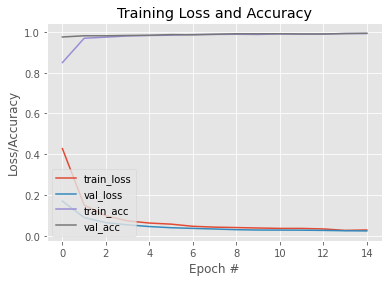

In [15]:
# Plot training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

plt

In [16]:
print("[INFO] Generating confusion matrix...")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

[INFO] Generating confusion matrix...


In [17]:
cm = confusion_matrix(y_true=testY.argmax(axis=1), y_pred = predIdxs)

In [18]:
cm

array([[596,   4],
       [  4, 596]])

In [19]:
# Function to plot confusion matrix, do not import the plot_confusion_matrix from sklearn.metrics because 
# we do not have estimator here.
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised Confusion Matrix")
    else:
        print("Confusion Matrix without Normalization")
        
    print(cm)
    
    thres = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center", color="white" if cm[i,j] > thres else "black")
        
    plt.tight_layout()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

Confusion Matrix without Normalization
[[596   4]
 [  4 596]]


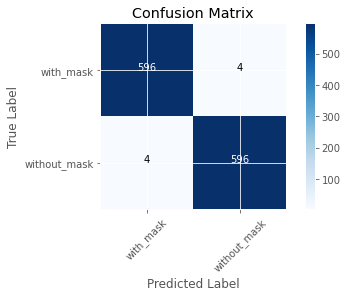

In [20]:

plot_confusion_matrix(cm=cm, classes=CATEGORIES, title="Confusion Matrix" )

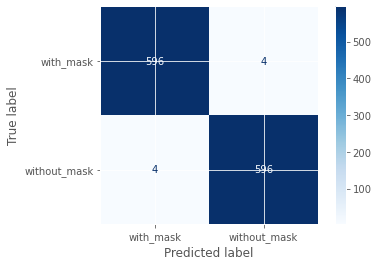

In [21]:
#Easier way of plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)

In [22]:
# SERIALIZE model to the disk
print("[INFO] saving mask detector model...")
model.save("3000facemask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/Users/leequan/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
